**Identifying features that influence low-income student success**

by Ben Lacar
<br>
updated May 2020

In [2]:
# Import packages

import os

# Dataframe munging and statistics
import re

import matplotlib

# Data visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import statsmodels.api as sm

# Stats
from scipy.stats import mannwhitneyu, ttest_ind
from sklearn import datasets, linear_model, metrics

# Unsupervised learning
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    plot_confusion_matrix,
    r2_score,
)

# Modeling
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats import multitest

%matplotlib inline

In [3]:
# Colors and formatting
# Got Google theme html colors from here https://imagecolorpicker.com
B_beige = "#CDA577"
B_brown = "#643E34"
B_slate = "#3F5B66"
B_dkgray = "#5A7E8E"
B_ltgray = "#6D949B"
B_green = "#01CB8B"
B_lime = "#D3F04A"

B_colors = [B_beige, B_brown, B_slate, B_dkgray, B_ltgray, B_green, B_lime]
B_colors_cat = [B_beige, B_green, B_brown, B_ltgray, B_slate, B_lime, B_dkgray]

# Code formatting Jupyter black
%load_ext nb_black

<IPython.core.display.Javascript object>

# Import data

In [4]:
parent_path = "/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study/"
os.chdir(parent_path)
os.getcwd()

'/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study'

<IPython.core.display.Javascript object>

In [5]:
# Import data from data cleaning
df_state_info_gs_census = pd.read_csv(
    "data/b_intermediate/df_state_info_gs_census_200514.csv", index_col=0
)

<IPython.core.display.Javascript object>

In [6]:
df_state_info_gs_census.shape

(966, 70)

<IPython.core.display.Javascript object>

In [7]:
df_state_info_gs_census.columns

Index(['NCESDist', 'NCESSchool', 'NCESDistSchool', 'StatusType', 'County',
       'District', 'School', 'Street', 'StreetAbr', 'City', 'Zip', 'zip_code',
       'State', 'Latitude', 'Longitude', 'E12',
       '%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months',
       '%; INCOME_BENEFITS - w/ Social Security',
       '%; INCOME_BENEFITS - w/ Supplemental Security Income',
       'Est.; INCOME_BENEFITS - Total households - Median household income ($)',
       'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
       'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)',
       '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage',
       '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage',
       '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage',
       '%; WORK_C

<IPython.core.display.Javascript object>

## Evaluate missing data

Text(0, 0.5, 'No. of features')

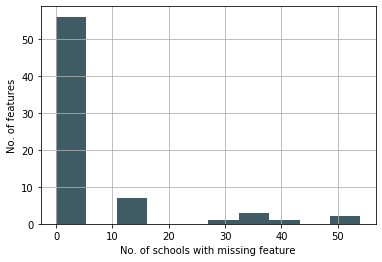

<IPython.core.display.Javascript object>

In [8]:
f, ax1 = plt.subplots()
df_state_info_gs_census.isna().sum().hist(ax=ax1, color=B_slate)
ax1.set_xlabel("No. of schools with missing feature")
ax1.set_ylabel("No. of features")

In [9]:
df_state_info_gs_census.isna().sum().sort_values(ascending=False).head(20)

test_scores_math_LIstudents                                                                          54
test_scores_math_LIstudents_n_students                                                               52
students_per_counselor                                                                               43
Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)    33
Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)                            33
Est.; INCOME_BENEFITS - Total households - Median household income ($)                               33
test_score_rating_notLIstudents                                                                      30
graduation_rates_UCCSU_eligibility_LIstudents                                                        13
graduation_rates_UCCSU_eligibility_allStudents                                                       13
graduation_rates_UCCSU_eligibility_nonLIstudents                

<IPython.core.display.Javascript object>

**What counties and districts are missing values of test scores?**

In [11]:
df_state_info_gs_census.loc[
    df_state_info_gs_census["test_scores_math_LIstudents"].isna(), :
].groupby("County").count().iloc[:, 0]

County
Alameda         4
Colusa          1
Fresno          2
Inyo            1
Kern            1
Los Angeles    34
Mendocino       3
Riverside       2
Sacramento      2
San Diego       1
San Joaquin     1
Siskiyou        1
Yolo            1
Name: NCESDist, dtype: int64

<IPython.core.display.Javascript object>

In [12]:
df_state_info_gs_census.loc[
    df_state_info_gs_census["test_scores_math_LIstudents"].isna(), :
].groupby("County").count().iloc[:, 0].sum()

54

<IPython.core.display.Javascript object>

In [13]:
df_state_info_gs_census.loc[
    df_state_info_gs_census["test_scores_math_LIstudents"].isna(), :
].groupby("District").count().iloc[:, 0]

District
Acton-Agua Dulce Unified            1
Borrego Springs Unified             1
Coachella Valley Unified            2
Delano Joint Union High             1
Esparto Unified                     1
Inyo County Office of Education     1
Laton Joint Unified                 1
Laytonville Unified                 1
Lennox                              1
Los Angeles Unified                30
Mendota Unified                     1
Oakland Unified                     4
Point Arena Joint Union High        1
Pomona Unified                      2
Round Valley Unified                1
Sacramento City Unified             1
Siskiyou Union High                 1
Stockton Unified                    1
Twin Rivers Unified                 1
Williams Unified                    1
Name: NCESDist, dtype: int64

<IPython.core.display.Javascript object>

In [14]:
df_state_info_gs_census = df_state_info_gs_census.dropna().copy()

<IPython.core.display.Javascript object>

In [15]:
print(
    "{0:d} schools have values for all {1:d} features".format(
        df_state_info_gs_census.shape[0], df_state_info_gs_census.shape[1]
    )
)

814 schools have values for all 70 features


<IPython.core.display.Javascript object>

**Assign the 0/1 value for exceptional schools for SPLICE as the target.**

In [16]:
thresh = (
    df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"].mean()
    + df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"].std()
)
df_state_info_gs_census["splice_high"] = 0
bool_splice_high = (
    df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"] > thresh
)
df_state_info_gs_census.loc[bool_splice_high, "splice_high"] = 1

<IPython.core.display.Javascript object>

# Split data into train-validation-test

Here are my definitions of these terms:
- train: set for recursive feature selection, using an initial set of model parameters
- validation: set for tuning of hyperparameters (e.g. tree depth)
- test: set that is held out completely until final model valuation (logistic regression vs. random forest)

I'll apply 60-20-20 split. This first split (80/20) is getting the test set separated. The other 80% of the data will be used in finding hyperparameters in a 4-fold cross-validation.

In [17]:
def get_split_data(X, y, testsize):

    # Keep rows only if there are no null values for that feature and target
    k_rows2keep = pd.merge(X, y, left_index=True, right_index=True).notnull().sum(
        axis=1
    ) == (X.shape[1] + 1)
    print(
        "No. of total schools before splitting (no null values for feature set or target): ",
        sum(k_rows2keep),
    )

    X = X.loc[k_rows2keep, :].copy()
    y = y[k_rows2keep].copy()

    # Split data between train and test_(and_holdout?)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=testsize, random_state=19
    )

    return X_train, X_test, y_train, y_test

<IPython.core.display.Javascript object>

**The dataset at this point contains columns that are not features that I want to include in the model (such as street address). The next cell creates a variable that includes the desired features.**

In [18]:
all_features_filt_wcensuscheck = df_state_info_gs_census.columns.tolist()[15::]

<IPython.core.display.Javascript object>

**Remove the target and eligibility for all students which is a superset of college eligibility for LI students.**

In [19]:
rm_feat = [
    "graduation_rates_UCCSU_eligibility_allStudents",
    "graduation_rates_UCCSU_eligibility_LIstudents",
    "splice_high",
]

all_features_filt_wcensuscheck_notarget = [
    x for x in all_features_filt_wcensuscheck if x not in rm_feat
]
target = "splice_high"

<IPython.core.display.Javascript object>

In [20]:
X = df_state_info_gs_census[all_features_filt_wcensuscheck_notarget].copy()
y = df_state_info_gs_census[target].copy()

<IPython.core.display.Javascript object>

In [21]:
X_train, X_test, y_train, y_test = get_split_data(X, y, 0.2)

No. of total schools before splitting (no null values for feature set or target):  814


<IPython.core.display.Javascript object>

# Logistic regression, target: exceptional schools

Similar to [this blog](https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5)

## Scale data

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_LR = scaler.transform(X_train)
X_test_LR = scaler.transform(X_test)

<IPython.core.display.Javascript object>

## Run 4-fold cross-validation to get optimal parameters

In [37]:
# Random forest classification parameters to test
random_grid_lr = {
    "penalty": ["l1", "l2"],
    "C": np.logspace(-4, 4, 20),
    "fit_intercept": [True],
    "solver": ["lbfgs", "liblinear"],
    "class_weight": ["balanced"],
}

<IPython.core.display.Javascript object>

In [38]:
# Instantiate model
log_reg = LogisticRegression()

# Randomized search using 4-fold cross-validation
log_reg_random = RandomizedSearchCV(
    estimator=log_reg,  # the model
    param_distributions=random_grid_lr,  # from above
    n_iter=5,  # no. of parameter settings sampled
    cv=4,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="f1",
    return_train_score=True,  # computationally expensive, but output here for insight
)

log_reg_random_search = log_reg_random.fit(X_train_LR, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished


<IPython.core.display.Javascript object>

In [39]:
print("List of hyperparameters for best fit: ", log_reg_random_search.best_params_)

List of hyperparameters for best fit:  {'solver': 'lbfgs', 'penalty': 'l2', 'fit_intercept': True, 'class_weight': 'balanced', 'C': 0.08858667904100823}


<IPython.core.display.Javascript object>

In [40]:
print(
    "Full list of hyperparameters: ", log_reg_random_search.best_estimator_.get_params()
)

Full list of hyperparameters:  {'C': 0.08858667904100823, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


<IPython.core.display.Javascript object>

**Fit model using hyperparameters.**

In [42]:
log_reg_best = LogisticRegression(**log_reg_random_search.best_params_)
log_reg_best.fit(X_train_LR, y_train)

LogisticRegression(C=0.08858667904100823, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

## Evalute optimized parameters on test (hold out) set

In [43]:
y_pred_LR = log_reg_best.predict(X_test_LR)
df_eval_LR = pd.DataFrame({"test": y_test, "pred": y_pred_LR})

<IPython.core.display.Javascript object>

In [44]:
confusion_matrix(df_eval_LR["test"], df_eval_LR["pred"])

array([[135,   9],
       [  5,  14]])

<IPython.core.display.Javascript object>

In [46]:
print(classification_report(df_eval_LR["test"], df_eval_LR["pred"]))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       144
           1       0.61      0.74      0.67        19

    accuracy                           0.91       163
   macro avg       0.79      0.84      0.81       163
weighted avg       0.92      0.91      0.92       163



<IPython.core.display.Javascript object>

Recall: 0.7368
Accuracy: 0.9141
Precision: 0.6087
[[135   9]
 [  5  14]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       144
           1       0.61      0.74      0.67        19

    accuracy                           0.91       163
   macro avg       0.79      0.84      0.81       163
weighted avg       0.92      0.91      0.92       163



''

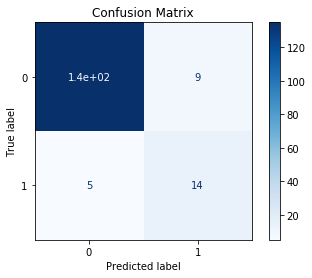

<IPython.core.display.Javascript object>

In [125]:
# Compute and print the confusion matrix and classification report
print('Recall: %.4f' %metrics.recall_score(df_eval_LR['test'], df_eval_LR['pred']))
print('Accuracy: %.4f' %log_reg_best.score(X_test_LR, y_test))
print('Precision: %.4f' %metrics.precision_score(df_eval_LR['test'], df_eval_LR['pred']))
print(confusion_matrix(df_eval_LR['test'], df_eval_LR['pred']))
print(classification_report(df_eval_LR['test'], df_eval_LR['pred']))

f, ax1 = plt.subplots()
plot_confusion_matrix(log_reg_best, X_test_LR, y_test, labels=None, 
                             sample_weight=None, normalize=None, display_labels=None, 
                             include_values=True, xticks_rotation='horizontal', 
                             values_format='d', cmap=plt.cm.Blues, ax=ax1)
ax1.set_title('Confusion Matrix');
;

## Most important features by logistic regression coefficients

                                                                                                   name  \
15  %; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting,...   
7                  %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage   
6     Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)   
34                                                                                           enrollment   
41                                                                               students_per_counselor   
25   %; INDUSTRY - Civilian employed pop. 16 yrs and up - Transportation and warehousing, and utilities   
11                            %; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled   
50                                                   graduation_rates_gradRates_eligibility_allStudents   
37                                   

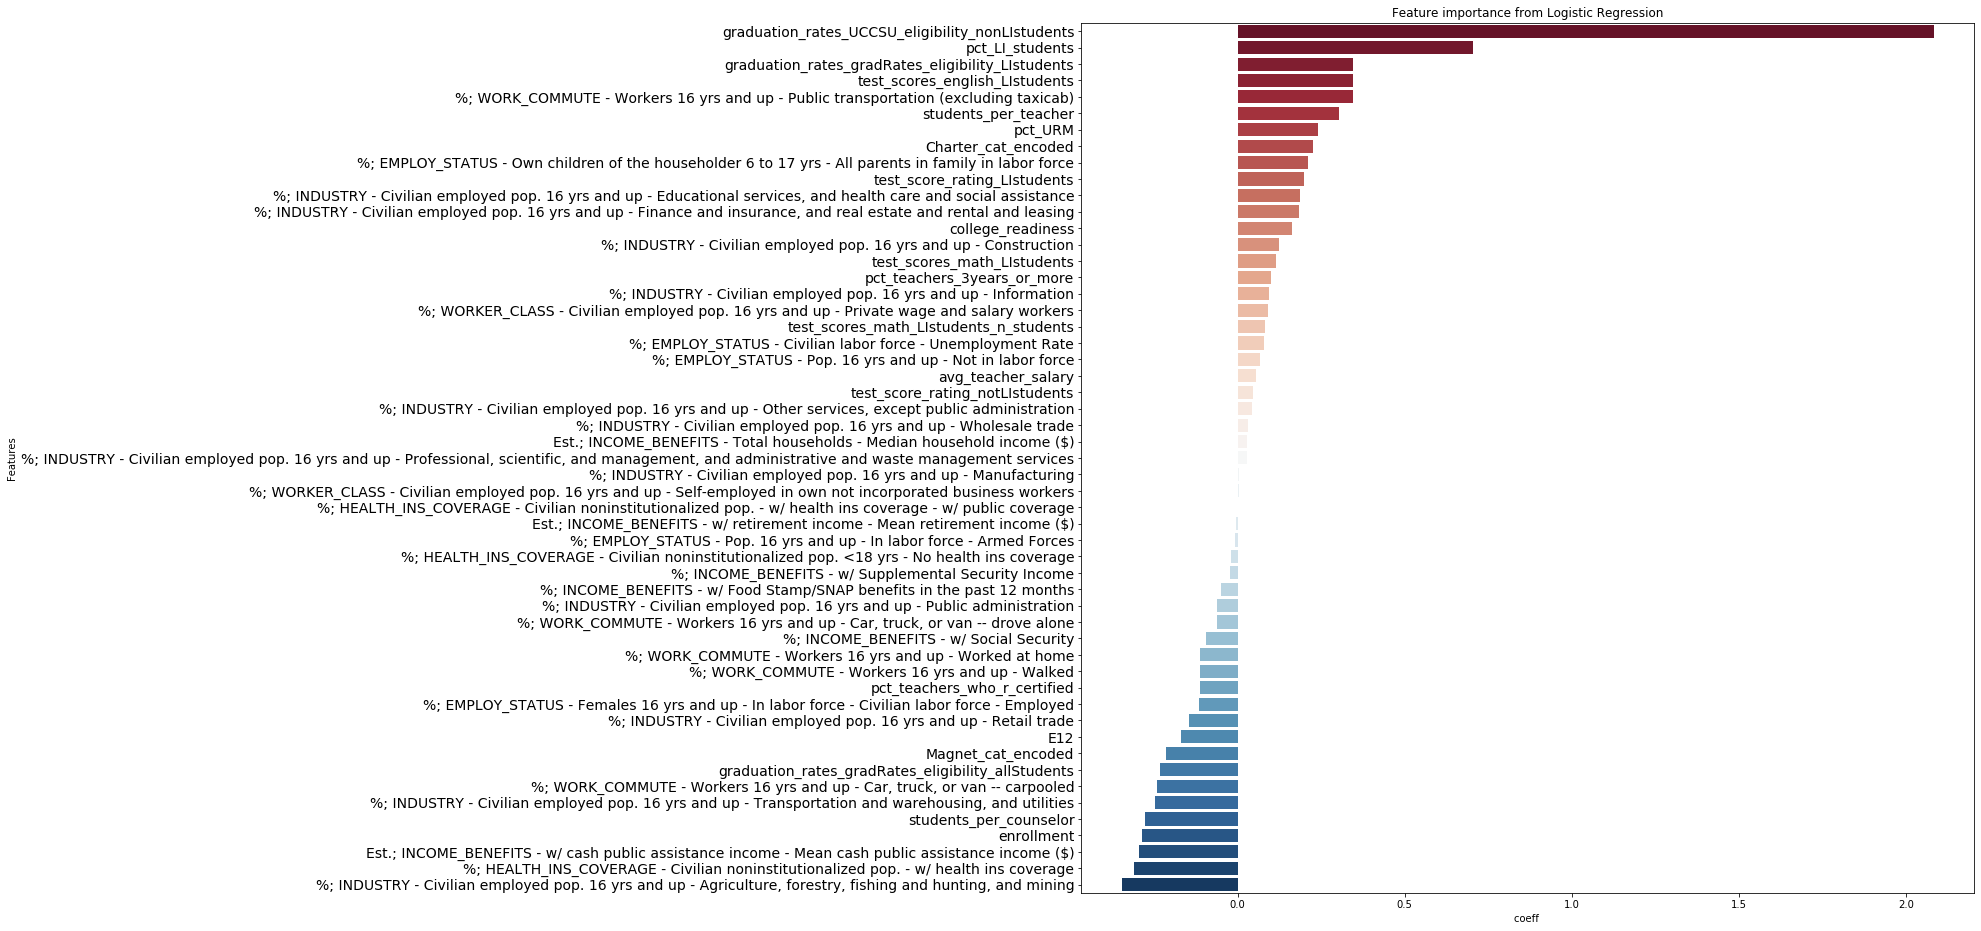

<IPython.core.display.Javascript object>

In [124]:
# calculate feature importance (coeff of logreg)
feature_importance = pd.DataFrame()
feature_importance["name"] = all_features_filt_wcensuscheck_notarget
feature_importance["coeff"] = log_reg_best.coef_[0]
print(feature_importance.sort_values(by=["coeff"]))

# plot feature importance (horizontal)

f, ax1 = plt.subplots(figsize=(16, 16))
sns.barplot(
    x="coeff",
    y="name",
    data=feature_importance.sort_values(by="coeff", ascending=False),
    palette="RdBu",
    ax=ax1,
)
ax1.tick_params(axis='y', labelsize=14) #to Set Tick Labels Font Size 
ax1.set_xlabel("coeff ")
ax1.set_ylabel("Features")
ax1.set_title("Feature importance from Logistic Regression")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')

figure_loc = "results/"
plt.savefig(figure_loc + 'LR_feature_coefficients.png', dpi=300, bbox_inches='tight')

In [48]:
feature_importance.sort_values(by=["coeff"])

,name,coeff
15,%; INDUSTRY - Civilian employed pop. 16 yrs an...,-0.345969
7,%; HEALTH_INS_COVERAGE - Civilian noninstituti...,-0.308674
6,Est.; INCOME_BENEFITS - w/ cash public assista...,-0.293524
34,enrollment,-0.286030
41,students_per_counselor,-0.276777
25,%; INDUSTRY - Civilian employed pop. 16 yrs an...,-0.246121
11,"%; WORK_COMMUTE - Workers 16 yrs and up - Car,...",-0.242378
50,graduation_rates_gradRates_eligibility_allStud...,-0.232714
37,Magnet_cat_encoded,-0.215442
0,E12,-0.168084


<IPython.core.display.Javascript object>

In [49]:
[print(i) for i in feature_importance.sort_values(by=["coeff"])["name"]]

%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage
Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)
enrollment
students_per_counselor
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Transportation and warehousing, and utilities
%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled
graduation_rates_gradRates_eligibility_allStudents
Magnet_cat_encoded
E12
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed
pct_teachers_who_r_certified
%; WORK_COMMUTE - Workers 16 yrs and up - Walked
%; WORK_COMMUTE - Workers 16 yrs and up - Worked at home
%; INCOME_BENEFITS - w/ Social Security
%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone
%; INDUSTRY - Civil

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<IPython.core.display.Javascript object>

# RF classification, target: exceptional schools

Standardizing features is not necessary for random forest.

## Run 4-fold cross-validation to get optimal parameters

In [51]:
# Random forest classification parameters to test
random_grid_rf = {
    "n_estimators": [50, 100, 500],
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 3, 4, 5, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced"],
}

<IPython.core.display.Javascript object>

In [52]:
# Instantiate model
rf = RandomForestClassifier()

# Randomized search using 4-fold cross-validation
rf_random = RandomizedSearchCV(
    estimator=rf,  # the model
    param_distributions=random_grid_rf,  # from above
    n_iter=5,  # no. of parameter settings sampled
    cv=4,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="f1",
    return_train_score=True,  # computationally expensive, but output here for insight
)

rf_random_search = rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.5s finished


<IPython.core.display.Javascript object>

In [53]:
print("Random forest best parameters from search: ", rf_random_search.best_params_)

Random forest best parameters from search:  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 4, 'criterion': 'gini', 'class_weight': 'balanced'}


<IPython.core.display.Javascript object>

In [54]:
rf_random_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

<IPython.core.display.Javascript object>

**Fit model using hyperparameters.**

In [55]:
rf_best = RandomForestClassifier(**rf_random_search.best_params_)
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<IPython.core.display.Javascript object>

## Evalute optimized parameters on test (hold out) set

In [56]:
y_pred_RF = rf_best.predict(X_test)
df_eval_RF = pd.DataFrame({"test": y_test, "pred": y_pred_RF})

<IPython.core.display.Javascript object>

Recall: 0.4737
Accuracy: 0.1166
Precision: 0.6429
[[139   5]
 [ 10   9]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       144
           1       0.64      0.47      0.55        19

    accuracy                           0.91       163
   macro avg       0.79      0.72      0.75       163
weighted avg       0.90      0.91      0.90       163



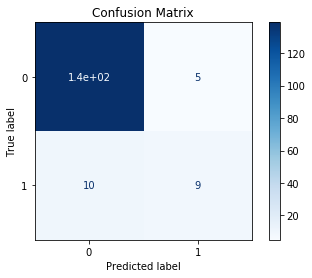

<IPython.core.display.Javascript object>

In [57]:
# Compute and print the confusion matrix and classification report
print('Recall: %.4f' %metrics.recall_score(df_eval_RF['test'], df_eval_RF['pred']))
print('Accuracy: %.4f' %log_reg_best.score(X_test, y_test))
print('Precision: %.4f' %metrics.precision_score(df_eval_RF['test'], df_eval_RF['pred']))
print(confusion_matrix(df_eval_RF['test'], df_eval_RF['pred']))
print(classification_report(df_eval_RF['test'], df_eval_RF['pred']))

f, ax1 = plt.subplots()
plot_confusion_matrix(rf_best, X_test, y_test, labels=None, 
                             sample_weight=None, normalize=None, display_labels=None, 
                             include_values=True, xticks_rotation='horizontal', 
                             values_format='d', cmap=plt.cm.Blues, ax=ax1)
ax1.set_title('Confusion Matrix');
;

In [326]:
# Roc curve

<IPython.core.display.Javascript object>

## Most important features from random forest

In [58]:
features = all_features_filt_wcensuscheck_notarget

<IPython.core.display.Javascript object>

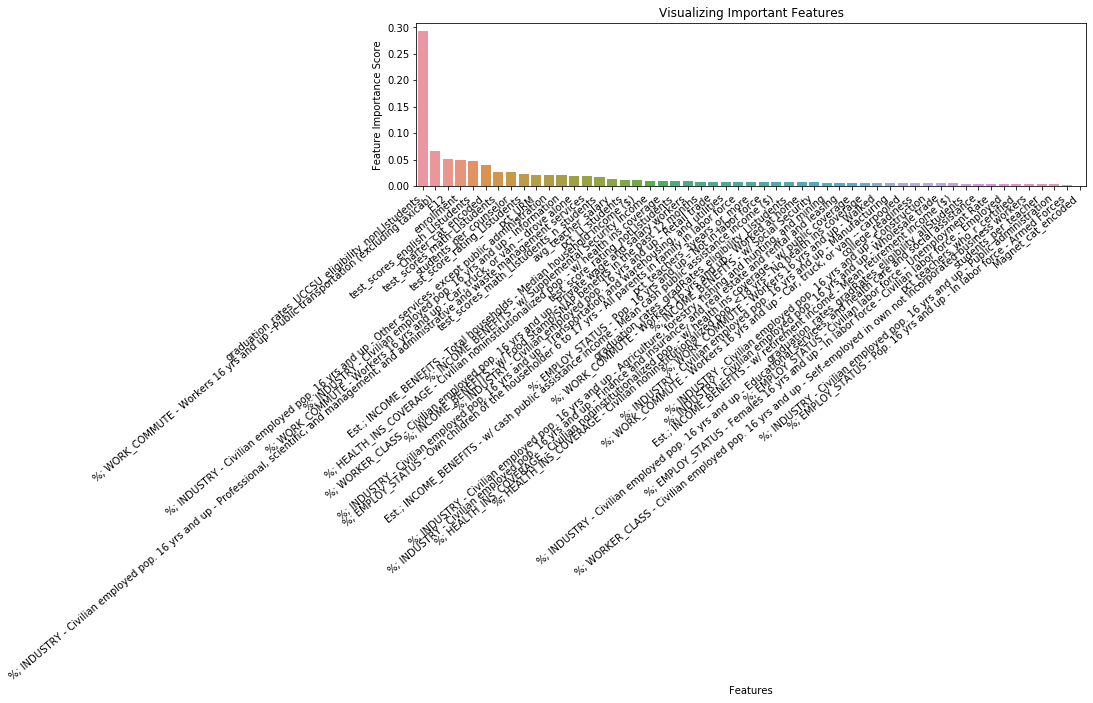

<IPython.core.display.Javascript object>

In [59]:
feature_imp = pd.Series(rf_best.feature_importances_,index=features).sort_values(ascending=False)

# Creating a bar plot
f, ax1 = plt.subplots(figsize=(12,3))
sns.barplot(y=feature_imp, x=feature_imp.index, ax=ax1)

# Add labels to your graph
ax1.set_xlabel('Features')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha='right')

ax1.set_ylabel('Feature Importance Score')
ax1.set_title('Visualizing Important Features');
;

In [60]:
pd.DataFrame(
    {
        "rank": range(1, len(feature_imp) + 1),
        "feature": feature_imp.index,
        "feature_imp_score": feature_imp.values,
    }
)

,rank,feature,feature_imp_score
0,1,graduation_rates_UCCSU_eligibility_nonLIstudents,0.293498
1,2,%; WORK_COMMUTE - Workers 16 yrs and up - Publ...,0.065527
2,3,E12,0.051464
3,4,enrollment,0.049574
4,5,test_scores_english_LIstudents,0.047572
5,6,Charter_cat_encoded,0.039930
6,7,test_scores_math_LIstudents,0.026866
7,8,students_per_counselor,0.025975
8,9,test_score_rating_LIstudents,0.023794
9,10,pct_URM,0.021268


<IPython.core.display.Javascript object>

In [61]:
feature_imp.sum()

1.0

<IPython.core.display.Javascript object>

## Features using SHAP values

In [62]:
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


<IPython.core.display.Javascript object>

**That output includes features on predicting both classes, but we'll focus on positive class with shap_values[1].**

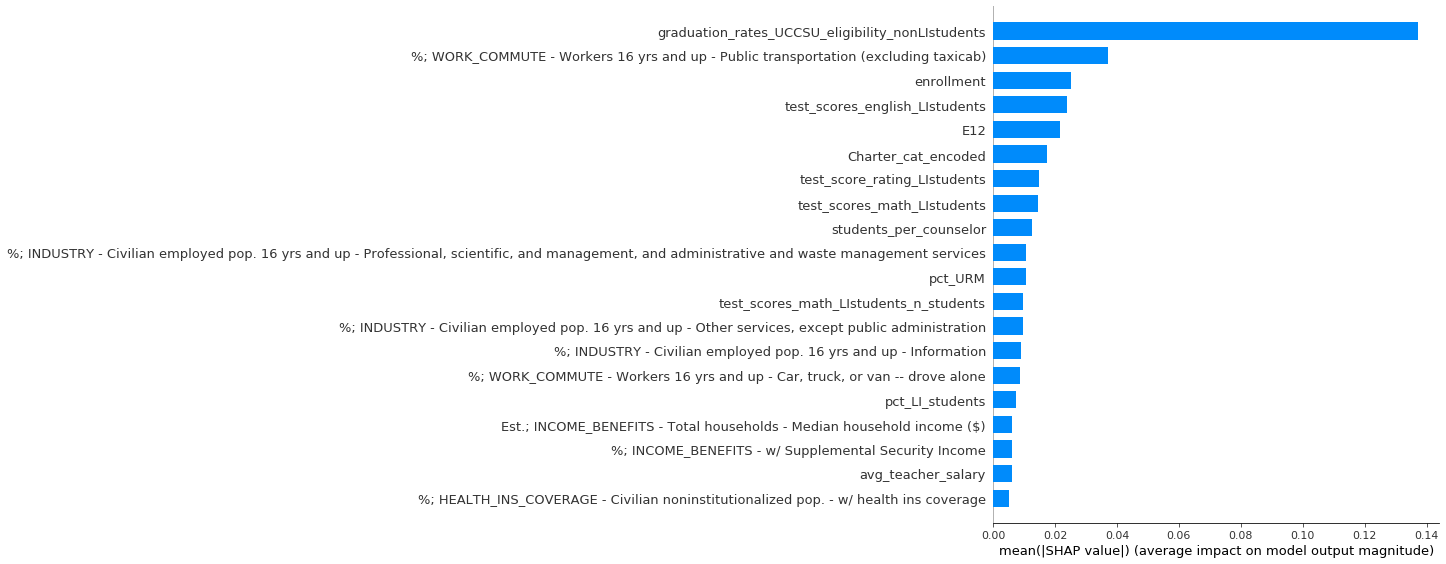

<IPython.core.display.Javascript object>

In [63]:
shap.summary_plot(shap_values[1], X_train, plot_type="bar")

In [64]:
def ABS_SHAP(df_shap, df, top_n):
    # import matplotlib as plt
    """
    Shows directionality (taken from blog post)
    """

    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop("index", axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i], df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list), pd.Series(corr_list)], axis=1).fillna(
        0
    )
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns = ["Variable", "Corr"]
    corr_df["Sign"] = np.where(corr_df["Corr"] > 0, "red", "blue")

    # Plot it
    shap_abs = np.abs(shap_v)
    k = pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ["Variable", "SHAP_abs"]
    k2 = k.merge(corr_df, left_on="Variable", right_on="Variable", how="inner")
    k2 = k2.sort_values(by="SHAP_abs", ascending=True).tail(
        top_n
    )  # Added top_n to limit features
    colorlist = k2["Sign"]
    ax = k2.plot.barh(
        x="Variable", y="SHAP_abs", color=colorlist, figsize=(20, 16), legend=False,
    )
    ax.set_yticklabels(labels=k2["Variable"], fontsize=24)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)", fontsize=24)
    ax.set_ylabel("")

    # return k2

    # ABS_SHAP(shap_values,X_train,top_n)
    # view rawABS_SHAP hosted with ❤ by GitHub

<IPython.core.display.Javascript object>

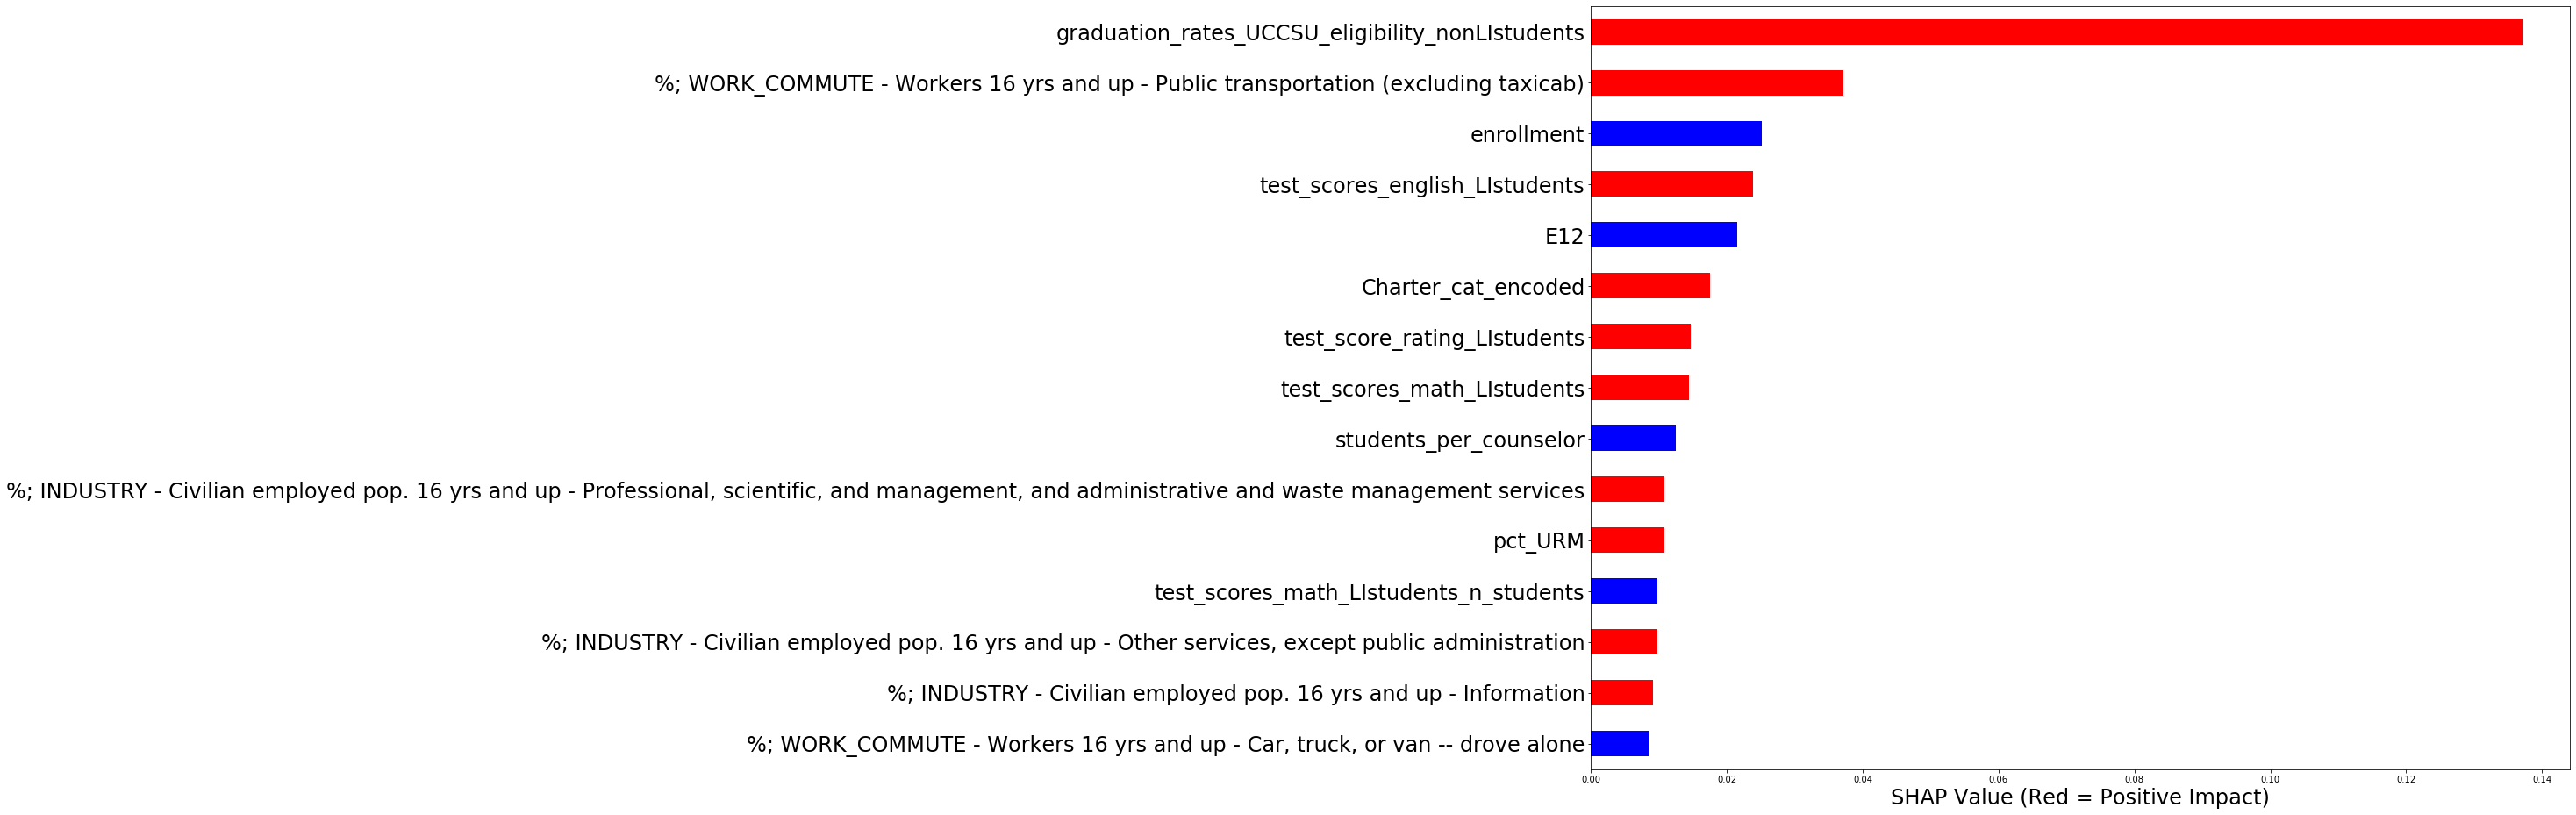

<IPython.core.display.Javascript object>

In [65]:
ABS_SHAP(shap_values[1], X_train, 15)

# Statistical analysis

In [66]:
def scatter_plot_open_circles(df, feature_x, feature_y, ax):
    x = df[feature_x]
    y = df[feature_y]
    ax.scatter(x, y, facecolors="none", edgecolors=B_dkgray)
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)

<IPython.core.display.Javascript object>

In [67]:
def hist_plot(df, feature, ax):
    df[feature].hist(ax=ax, bins=30, color=B_slate)
    ax.set_title(feature)

<IPython.core.display.Javascript object>

In [68]:
def run_mannwhitneyu(df, metric_col, bin_col):
    class0 = sorted(df[bin_col].unique())[0]
    class1 = sorted(df[bin_col].unique())[1]
    x = df.loc[df[bin_col] == class0, metric_col]
    y = df.loc[df[bin_col] == class1, metric_col]
    mwu_statistic, mwu_pval = mannwhitneyu(x, y, use_continuity=True, alternative=None)
    return mwu_pval

<IPython.core.display.Javascript object>

mean:  45.75675675675676
mean +/- 1SD:  28.30494864995583 63.20856486355768


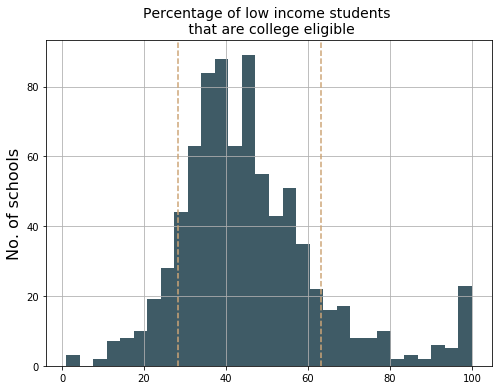

<IPython.core.display.Javascript object>

In [69]:
f, ax1 = plt.subplots(figsize=(8,6))
hist_plot(df_state_info_gs_census, "graduation_rates_UCCSU_eligibility_LIstudents", ax1)
ax1.set_ylabel("No. of schools", fontsize=16)
ax1.set_title("Percentage of low income students \n that are college eligible", fontsize=14);

target = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]
target_mean = target.mean()
target_sd = target.std()

# or top and bottom quantile

ax1.axvline(target_mean-target_sd, c=B_beige, linestyle="dashed")
ax1.axvline(target_mean+target_sd, c=B_beige, linestyle="dashed")

print("mean: ", target_mean)
print("mean +/- 1SD: ", target_mean - target_sd, target_mean + target_sd);
;

In [70]:
feat_for_stats_test = all_features_filt_wcensuscheck_notarget
feat_for_stats_test[0:5]

['E12',
 '%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months',
 '%; INCOME_BENEFITS - w/ Social Security',
 '%; INCOME_BENEFITS - w/ Supplemental Security Income',
 'Est.; INCOME_BENEFITS - Total households - Median household income ($)']

<IPython.core.display.Javascript object>

## Evaluate exceptional vs. non-exceptional schoools

In [71]:
df_state_info_gs_census["splice_high"].head()

0    1
1    0
4    0
5    0
6    0
Name: splice_high, dtype: int64

<IPython.core.display.Javascript object>

In [72]:
df_state_info_gs_census_forMW_splice_high = df_state_info_gs_census.loc[
    :, feat_for_stats_test + ["splice_high"]
].copy()

<IPython.core.display.Javascript object>

In [126]:
df_state_info_gs_census_forMW_splice_high.head()

,E12,%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months,%; INCOME_BENEFITS - w/ Social Security,%; INCOME_BENEFITS - w/ Supplemental Security Income,Est.; INCOME_BENEFITS - Total households - Median household income ($),Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($),Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($),%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage,...,avg_teacher_salary,test_score_rating_LIstudents,test_score_rating_notLIstudents,test_scores_english_LIstudents,test_scores_math_LIstudents,test_scores_math_LIstudents_n_students,graduation_rates_gradRates_eligibility_allStudents,graduation_rates_gradRates_eligibility_LIstudents,graduation_rates_UCCSU_eligibility_nonLIstudents,splice_high
0,88,9.2,24.0,16.0,32993.0,29027.0,5055.0,82.2,41.3,4.7,...,56500.0,4.0,4.0,47.0,18.0,77.0,82.0,83.0,100.000000,1
1,381,6.1,21.9,5.0,72884.0,32115.0,4632.0,89.9,25.8,6.0,...,67831.0,8.0,10.0,64.0,49.0,104.0,95.0,94.0,69.512195,0
4,285,4.0,19.7,3.3,80970.0,36487.0,4229.0,94.3,19.0,2.4,...,99680.0,8.0,10.0,66.0,45.0,55.0,93.0,92.0,66.686747,0
5,798,3.6,9.5,2.8,26478.0,40397.0,8172.0,92.8,11.1,1.5,...,68887.0,5.0,10.0,45.0,27.0,172.0,89.0,89.0,72.222222,0
6,702,5.1,29.2,4.0,76269.0,32035.0,6020.0,91.9,26.2,2.7,...,80378.0,7.0,9.0,56.0,51.0,144.0,97.0,96.0,63.500000,0


<IPython.core.display.Javascript object>

In [74]:
df_sig_features = pd.DataFrame()
df_sig_features["feature"] = None
df_sig_features["raw_pval"] = None

for i, feature in enumerate(feat_for_stats_test):
    mwu_pval_feature = run_mannwhitneyu(
        df_state_info_gs_census_forMW_splice_high, feature, "splice_high"
    )

    df_sig_features.loc[i, "feature"] = feature
    df_sig_features.loc[i, "raw_pval"] = mwu_pval_feature

df_sig_features = df_sig_features.sort_values(
    by="raw_pval", ascending=True
).reset_index()

bonferroni_reject, bonferroni_p_val_corrected = multitest.multipletests(
    df_sig_features["raw_pval"], alpha=0.05, method="bonferroni"
)[0:2]

df_sig_features["corr_p_val_rej"] = bonferroni_reject
df_sig_features["corr_p_val"] = bonferroni_p_val_corrected

<IPython.core.display.Javascript object>

In [75]:
df_sig_features

,index,feature,raw_pval,corr_p_val_rej,corr_p_val
0,52,graduation_rates_UCCSU_eligibility_nonLIstudents,2.98419e-47,True,1.58162e-45
1,38,Charter_cat_encoded,4.61339e-43,True,2.4451e-41
2,12,%; WORK_COMMUTE - Workers 16 yrs and up - Publ...,2.56104e-14,True,1.35735e-12
3,47,test_scores_english_LIstudents,2.63159e-12,True,1.39474e-10
4,34,enrollment,4.74387e-10,True,2.51425e-08
5,0,E12,1.05372e-09,True,5.58473e-08
6,45,test_score_rating_LIstudents,1.75257e-09,True,9.28861e-08
7,41,students_per_counselor,3.6904e-09,True,1.95591e-07
8,49,test_scores_math_LIstudents_n_students,4.70186e-09,True,2.49198e-07
9,19,%; INDUSTRY - Civilian employed pop. 16 yrs an...,1.11113e-08,True,5.88899e-07


<IPython.core.display.Javascript object>

In [76]:
[print(i, v) for i, v in enumerate(df_sig_features["feature"]) if i < 21]

0 graduation_rates_UCCSU_eligibility_nonLIstudents
1 Charter_cat_encoded
2 %; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
3 test_scores_english_LIstudents
4 enrollment
5 E12
6 test_score_rating_LIstudents
7 students_per_counselor
8 test_scores_math_LIstudents_n_students
9 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Information
10 %; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone
11 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services
12 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
13 %; INCOME_BENEFITS - w/ Social Security
14 test_scores_math_LIstudents
15 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade
16 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration
17 pct_LI_students
18 avg_teacher_salary
19 %; WORKER_CLASS - Civil

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<IPython.core.display.Javascript object>

### Inspect Mann-Whitney p-values and logistic regression coefficients

In [77]:
# From above
df_sig_features.head()

,index,feature,raw_pval,corr_p_val_rej,corr_p_val
0,52,graduation_rates_UCCSU_eligibility_nonLIstudents,2.98419e-47,True,1.58162e-45
1,38,Charter_cat_encoded,4.61339e-43,True,2.4451e-41
2,12,%; WORK_COMMUTE - Workers 16 yrs and up - Publ...,2.56104e-14,True,1.35735e-12
3,47,test_scores_english_LIstudents,2.63159e-12,True,1.39474e-10
4,34,enrollment,4.74387e-10,True,2.51425e-08


<IPython.core.display.Javascript object>

In [78]:
# From logistic regression
feature_importance.head()

,name,coeff
0,E12,-0.168084
1,%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...,-0.050005
2,%; INCOME_BENEFITS - w/ Social Security,-0.094234
3,%; INCOME_BENEFITS - w/ Supplemental Security ...,-0.021387
4,Est.; INCOME_BENEFITS - Total households - Med...,0.029293


<IPython.core.display.Javascript object>

### Significant features by logistic regression coefficient and MW p-value

- Filter by p-value and absoltue value of coefficient

In [79]:
df_sig_features_LRcoeff = pd.merge(
    df_sig_features, feature_importance, left_on="feature", right_on="name"
).loc[:, ["feature", "corr_p_val", "coeff"]]
df_sig_features_LRcoeff.head()

,feature,corr_p_val,coeff
0,graduation_rates_UCCSU_eligibility_nonLIstudents,1.58162e-45,2.081267
1,Charter_cat_encoded,2.4451e-41,0.226145
2,%; WORK_COMMUTE - Workers 16 yrs and up - Publ...,1.35735e-12,0.343655
3,test_scores_english_LIstudents,1.39474e-10,0.343822
4,enrollment,2.51425e-08,-0.286030


<IPython.core.display.Javascript object>

In [80]:
df_sig_features_LRcoeff["abs_coeff"] = np.abs(df_sig_features_LRcoeff["coeff"].copy())

<IPython.core.display.Javascript object>

In [81]:
pd.set_option("max_colwidth", 100)

<IPython.core.display.Javascript object>

In [82]:
df_sig_features_LRcoeff.sort_values(by="coeff")

,feature,corr_p_val,coeff,abs_coeff
12,"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting,...",9.12814e-05,-0.345969,0.345969
30,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage,0.470717,-0.308674,0.308674
32,Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($),0.960022,-0.293524,0.293524
4,enrollment,2.51425e-08,-0.286030,0.286030
7,students_per_counselor,1.95591e-07,-0.276777,0.276777
37,"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Transportation and warehousing, and utilities",1,-0.246121,0.246121
25,"%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled",0.096861,-0.242378,0.242378
42,graduation_rates_gradRates_eligibility_allStudents,1,-0.232714,0.232714
50,Magnet_cat_encoded,1,-0.215442,0.215442
5,E12,5.58473e-08,-0.168084,0.168084


<IPython.core.display.Javascript object>

In [83]:
bool_coeff_mwpval = (df_sig_features_LRcoeff["corr_p_val"] < 0.05) & (
    df_sig_features_LRcoeff["abs_coeff"] > 0.1
)
df_sig_features_LRcoeff[bool_coeff_mwpval]

,feature,corr_p_val,coeff,abs_coeff
0,graduation_rates_UCCSU_eligibility_nonLIstudents,1.58162e-45,2.081267,2.081267
1,Charter_cat_encoded,2.4451e-41,0.226145,0.226145
2,%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab),1.35735e-12,0.343655,0.343655
3,test_scores_english_LIstudents,1.39474e-10,0.343822,0.343822
4,enrollment,2.51425e-08,-0.286030,0.286030
5,E12,5.58473e-08,-0.168084,0.168084
6,test_score_rating_LIstudents,9.28861e-08,0.197880,0.197880
7,students_per_counselor,1.95591e-07,-0.276777,0.276777
12,"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting,...",9.12814e-05,-0.345969,0.345969
14,test_scores_math_LIstudents,0.000348327,0.113715,0.113715


<IPython.core.display.Javascript object>

In [84]:
len(df_sig_features_LRcoeff[bool_coeff_mwpval])

13

<IPython.core.display.Javascript object>

In [85]:
[print(i) for i in df_sig_features_LRcoeff.loc[bool_coeff_mwpval, "feature"]]

graduation_rates_UCCSU_eligibility_nonLIstudents
Charter_cat_encoded
%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
test_scores_english_LIstudents
enrollment
E12
test_score_rating_LIstudents
students_per_counselor
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
test_scores_math_LIstudents
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade
pct_LI_students
pct_teachers_who_r_certified


[None, None, None, None, None, None, None, None, None, None, None, None, None]

<IPython.core.display.Javascript object>

### Features that have low coefficients and high p-values

In [112]:
bool_lowcoeff_highmwpval = (df_sig_features_LRcoeff["corr_p_val"] > 0.05) & (
    df_sig_features_LRcoeff["abs_coeff"] < 0.1
)
df_sig_features_LRcoeff[bool_lowcoeff_highmwpval]

,feature,corr_p_val,coeff,abs_coeff
22,%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force,0.0581402,0.065511,0.065511
24,"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Other services, except public administration",0.0957304,0.044471,0.044471
26,test_score_rating_notLIstudents,0.143653,0.046063,0.046063
34,%; INDUSTRY - Civilian employed pop. 16 yrs and up - Wholesale trade,1,0.031630,0.031630
36,Est.; INCOME_BENEFITS - Total households - Median household income ($),1,0.029293,0.029293
38,%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months,1,-0.050005,0.050005
39,%; INCOME_BENEFITS - w/ Supplemental Security Income,1,-0.021387,0.021387
43,%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate,1,0.080417,0.080417
44,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public...,1,0.000818,0.000818
45,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage,1,-0.019365,0.019365


<IPython.core.display.Javascript object>

In [119]:
(df_sig_features_LRcoeff['abs_coeff']>0.1).sum()

31

<IPython.core.display.Javascript object>

In [120]:
df_sig_features_LRcoeff.shape

(53, 4)

<IPython.core.display.Javascript object>

## Boxplots of features

In [105]:
df_sig_features_LRcoeff

,feature,corr_p_val,coeff,abs_coeff
0,graduation_rates_UCCSU_eligibility_nonLIstudents,1.58162e-45,2.081267,2.081267
1,Charter_cat_encoded,2.4451e-41,0.226145,0.226145
2,%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab),1.35735e-12,0.343655,0.343655
3,test_scores_english_LIstudents,1.39474e-10,0.343822,0.343822
4,enrollment,2.51425e-08,-0.286030,0.286030
5,E12,5.58473e-08,-0.168084,0.168084
6,test_score_rating_LIstudents,9.28861e-08,0.197880,0.197880
7,students_per_counselor,1.95591e-07,-0.276777,0.276777
8,test_scores_math_LIstudents_n_students,2.49198e-07,0.081766,0.081766
9,%; INDUSTRY - Civilian employed pop. 16 yrs and up - Information,5.88899e-07,0.092525,0.092525


<IPython.core.display.Javascript object>

Charter_cat_encoded
enrollment
E12


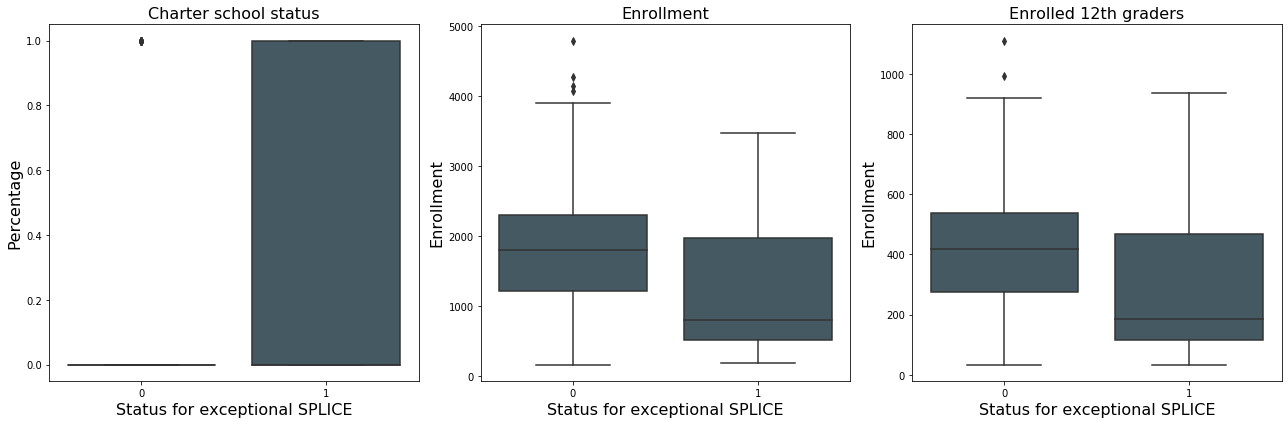

<IPython.core.display.Javascript object>

In [106]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Enter feature by index above
feature_rank_to_plot = [1,4,5]

# First feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax1,
)

ax1.set_title("Charter school status", fontsize=16)
ax1.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax2,
)

ax2.set_title("Enrollment", fontsize=16)
ax2.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax2.set_ylabel("Enrollment", fontsize=16)

# Third feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax3,
)

ax3.set_title("Enrolled 12th graders", fontsize=16)
ax3.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax3.set_ylabel("Enrollment", fontsize=16)

plt.tight_layout();
;

enrollment
E12
students_per_teacher


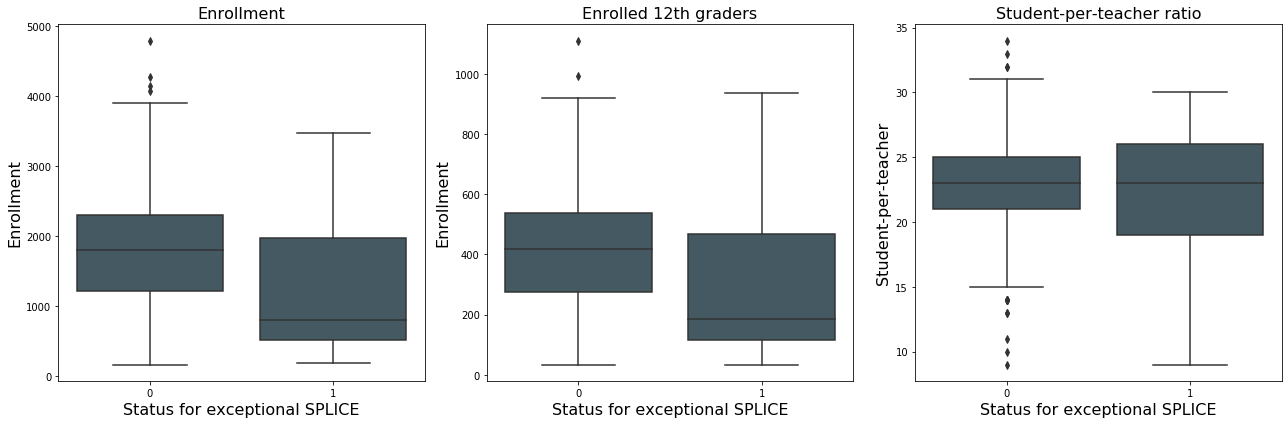

<IPython.core.display.Javascript object>

In [110]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [4,5,41]

# First feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax1,
)

ax1.set_title("Enrollment", fontsize=16)
ax1.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax1.set_ylabel("Enrollment", fontsize=16)

# Second feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax2,
)

ax2.set_title("Enrolled 12th graders", fontsize=16)
ax2.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax2.set_ylabel("Enrollment", fontsize=16)


# Third feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax3,
)

ax3.set_title("Student-per-teacher ratio", fontsize=16)
ax3.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax3.set_ylabel("Student-per-teacher", fontsize=16)

plt.tight_layout();
;

%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade


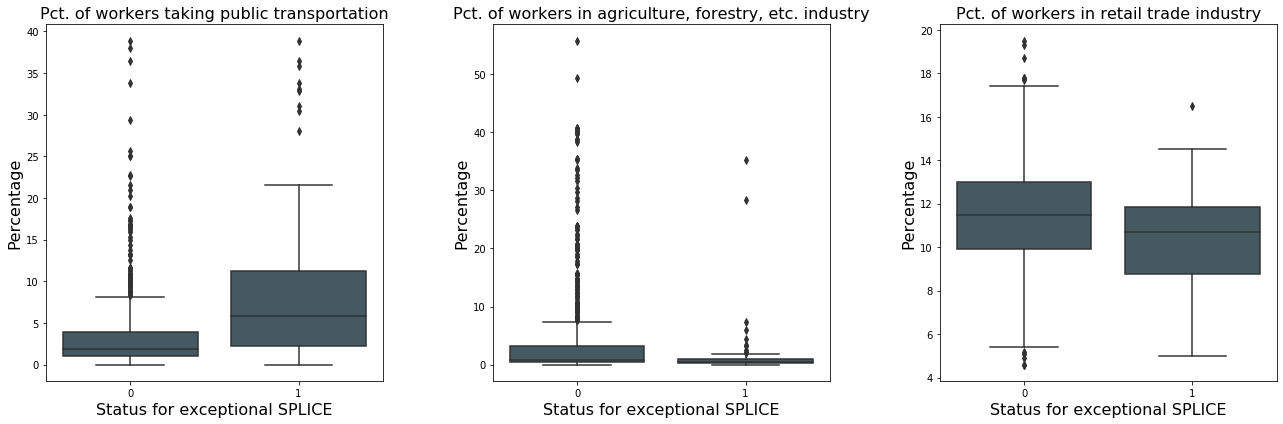

<IPython.core.display.Javascript object>

In [100]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [2, 12, 15]

# First feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax1,
)

ax1.set_title("Pct. of workers taking public transportation", fontsize=16)
ax1.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax2,
)

ax2.set_title("Pct. of workers in agriculture, forestry, etc. industry", fontsize=16)
ax2.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax3,
)

ax3.set_title("Pct. of workers in retail trade industry", fontsize=16)
ax3.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();
;

%; INCOME_BENEFITS - w/ Social Security
Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)
Est.; INCOME_BENEFITS - Total households - Median household income ($)


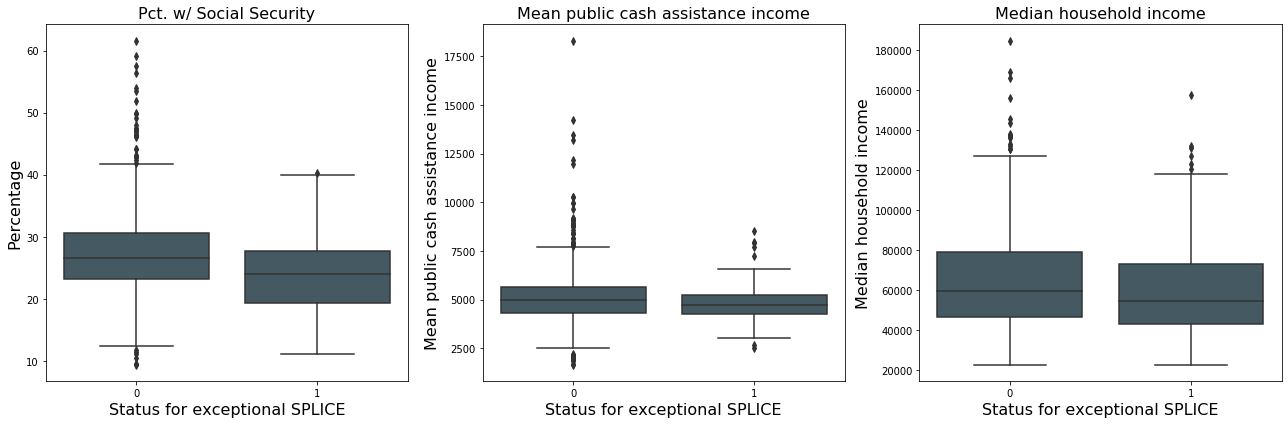

<IPython.core.display.Javascript object>

In [114]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [13, 32, 36]

# First feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax1,
)

ax1.set_title("Pct. w/ Social Security", fontsize=16)
ax1.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax2,
)

ax2.set_title("Mean public cash assistance income", fontsize=16)
ax2.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax2.set_ylabel("Mean public cash assistance income", fontsize=16)

# Third feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax3,
)

ax3.set_title("Median household income", fontsize=16)
ax3.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax3.set_ylabel("Median household income", fontsize=16)

plt.tight_layout();
;

%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage


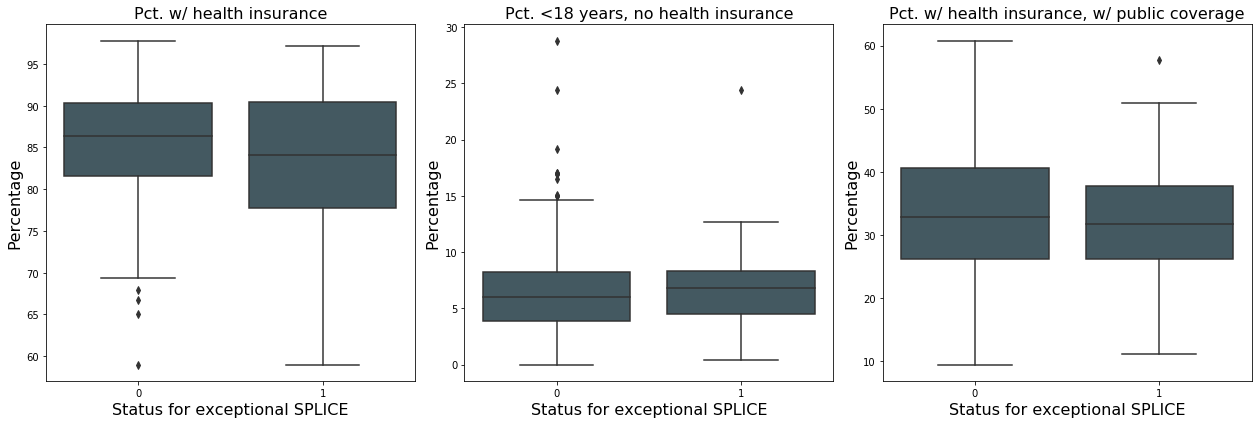

<IPython.core.display.Javascript object>

In [116]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [30, 45, 44]

# First feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax1,
)

ax1.set_title("Pct. w/ health insurance", fontsize=16)
ax1.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax2,
)

ax2.set_title("Pct. <18 years, no health insurance", fontsize=16)
ax2.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features_LRcoeff.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW_splice_high,
    x="splice_high",
    y=df_sig_features_LRcoeff.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=[0, 1],
    ax=ax3,
)

ax3.set_title("Pct. w/ health insurance, w/ public coverage", fontsize=16)
ax3.set_xlabel("Status for exceptional SPLICE", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();
;

## Analysis with t-test

In [130]:
def run_ttest(df, metric_col, bin_col):
    class0 = sorted(df[bin_col].unique())[0]
    class1 = sorted(df[bin_col].unique())[1]
    x = df.loc[df[bin_col] == class0, metric_col]
    y = df.loc[df[bin_col] == class1, metric_col]
    tt_statistic, tt_pval = ttest_ind(x, y, equal_var=False)
    return tt_pval

<IPython.core.display.Javascript object>

In [131]:
df_state_info_gs_census_forTT_splice_high = df_state_info_gs_census.loc[
    :, feat_for_stats_test + ["splice_high"]
].copy()

<IPython.core.display.Javascript object>

In [132]:
df_state_info_gs_census_forTT_splice_high.head()

,E12,%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months,%; INCOME_BENEFITS - w/ Social Security,%; INCOME_BENEFITS - w/ Supplemental Security Income,Est.; INCOME_BENEFITS - Total households - Median household income ($),Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($),Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($),%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage,...,avg_teacher_salary,test_score_rating_LIstudents,test_score_rating_notLIstudents,test_scores_english_LIstudents,test_scores_math_LIstudents,test_scores_math_LIstudents_n_students,graduation_rates_gradRates_eligibility_allStudents,graduation_rates_gradRates_eligibility_LIstudents,graduation_rates_UCCSU_eligibility_nonLIstudents,splice_high
0,88,9.2,24.0,16.0,32993.0,29027.0,5055.0,82.2,41.3,4.7,...,56500.0,4.0,4.0,47.0,18.0,77.0,82.0,83.0,100.000000,1
1,381,6.1,21.9,5.0,72884.0,32115.0,4632.0,89.9,25.8,6.0,...,67831.0,8.0,10.0,64.0,49.0,104.0,95.0,94.0,69.512195,0
4,285,4.0,19.7,3.3,80970.0,36487.0,4229.0,94.3,19.0,2.4,...,99680.0,8.0,10.0,66.0,45.0,55.0,93.0,92.0,66.686747,0
5,798,3.6,9.5,2.8,26478.0,40397.0,8172.0,92.8,11.1,1.5,...,68887.0,5.0,10.0,45.0,27.0,172.0,89.0,89.0,72.222222,0
6,702,5.1,29.2,4.0,76269.0,32035.0,6020.0,91.9,26.2,2.7,...,80378.0,7.0,9.0,56.0,51.0,144.0,97.0,96.0,63.500000,0


<IPython.core.display.Javascript object>

In [133]:
df_sig_features_TT = pd.DataFrame()
df_sig_features_TT["feature"] = None
df_sig_features_TT["raw_pval"] = None

for i, feature in enumerate(feat_for_stats_test):
    mwu_pval_feature = run_ttest(
        df_state_info_gs_census_forMW_splice_high, feature, "splice_high"
    )

    df_sig_features_TT.loc[i, "feature"] = feature
    df_sig_features_TT.loc[i, "raw_pval"] = mwu_pval_feature

df_sig_features_TT = df_sig_features_TT.sort_values(
    by="raw_pval", ascending=True
).reset_index()

bonferroni_reject, bonferroni_p_val_corrected = multitest.multipletests(
    df_sig_features_TT["raw_pval"], alpha=0.05, method="bonferroni"
)[0:2]

df_sig_features_TT["corr_p_val_rej"] = bonferroni_reject
df_sig_features_TT["corr_p_val"] = bonferroni_p_val_corrected

<IPython.core.display.Javascript object>

In [134]:
df_sig_features_TT

,index,feature,raw_pval,corr_p_val_rej,corr_p_val
0,52,graduation_rates_UCCSU_eligibility_nonLIstudents,4.36861e-48,True,2.31536e-46
1,38,Charter_cat_encoded,3.15172e-11,True,1.67041e-09
2,41,students_per_counselor,3.09003e-10,True,1.63772e-08
3,47,test_scores_english_LIstudents,3.68359e-10,True,1.9523e-08
4,34,enrollment,3.94717e-08,True,2.092e-06
5,45,test_score_rating_LIstudents,5.76896e-08,True,3.05755e-06
6,49,test_scores_math_LIstudents_n_students,6.42859e-08,True,3.40715e-06
7,12,%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab),8.98342e-08,True,4.76121e-06
8,0,E12,1.32267e-07,True,7.01014e-06
9,2,%; INCOME_BENEFITS - w/ Social Security,1.92045e-06,True,0.000101784


<IPython.core.display.Javascript object>

In [135]:
[print(i, v) for i, v in enumerate(df_sig_features_TT["feature"]) if i < 18]

0 graduation_rates_UCCSU_eligibility_nonLIstudents
1 Charter_cat_encoded
2 students_per_counselor
3 test_scores_english_LIstudents
4 enrollment
5 test_score_rating_LIstudents
6 test_scores_math_LIstudents_n_students
7 %; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
8 E12
9 %; INCOME_BENEFITS - w/ Social Security
10 %; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone
11 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
12 test_scores_math_LIstudents
13 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services
14 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Information
15 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade
16 %; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force
17 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<IPython.core.display.Javascript object>

### Inspect t-test p-values and logistic regression coefficients

In [136]:
# From above
df_sig_features_TT.head()

,index,feature,raw_pval,corr_p_val_rej,corr_p_val
0,52,graduation_rates_UCCSU_eligibility_nonLIstudents,4.36861e-48,True,2.31536e-46
1,38,Charter_cat_encoded,3.15172e-11,True,1.67041e-09
2,41,students_per_counselor,3.09003e-10,True,1.63772e-08
3,47,test_scores_english_LIstudents,3.68359e-10,True,1.9523e-08
4,34,enrollment,3.94717e-08,True,2.092e-06


<IPython.core.display.Javascript object>

In [137]:
# From logistic regression
feature_importance.head()

,name,coeff
0,E12,-0.168084
1,%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months,-0.050005
2,%; INCOME_BENEFITS - w/ Social Security,-0.094234
3,%; INCOME_BENEFITS - w/ Supplemental Security Income,-0.021387
4,Est.; INCOME_BENEFITS - Total households - Median household income ($),0.029293


<IPython.core.display.Javascript object>

In [138]:
feature_importance.tail()

,name,coeff
48,test_scores_math_LIstudents,0.113715
49,test_scores_math_LIstudents_n_students,0.081766
50,graduation_rates_gradRates_eligibility_allStudents,-0.232714
51,graduation_rates_gradRates_eligibility_LIstudents,0.346408
52,graduation_rates_UCCSU_eligibility_nonLIstudents,2.081267


<IPython.core.display.Javascript object>

### Significant features by logistic regression coefficient and t-test p-value

- Filter by p-value and absoltue value of coefficient

In [139]:
df_sig_features_TT_LRcoeff = pd.merge(
    df_sig_features_TT, feature_importance, left_on="feature", right_on="name"
).loc[:, ["feature", "corr_p_val", "coeff"]]
df_sig_features_TT_LRcoeff.head()

,feature,corr_p_val,coeff
0,graduation_rates_UCCSU_eligibility_nonLIstudents,2.31536e-46,2.081267
1,Charter_cat_encoded,1.67041e-09,0.226145
2,students_per_counselor,1.63772e-08,-0.276777
3,test_scores_english_LIstudents,1.9523e-08,0.343822
4,enrollment,2.092e-06,-0.286030


<IPython.core.display.Javascript object>

In [140]:
df_sig_features_TT_LRcoeff["abs_coeff"] = np.abs(df_sig_features_TT_LRcoeff["coeff"].copy())

<IPython.core.display.Javascript object>

In [141]:
pd.set_option("max_colwidth", 100)

<IPython.core.display.Javascript object>

In [142]:
df_sig_features_TT_LRcoeff.sort_values(by="coeff")

,feature,corr_p_val,coeff,abs_coeff
11,"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting,...",0.000194617,-0.345969,0.345969
26,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage,0.819815,-0.308674,0.308674
25,Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($),0.575778,-0.293524,0.293524
4,enrollment,2.092e-06,-0.286030,0.286030
2,students_per_counselor,1.63772e-08,-0.276777,0.276777
40,"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Transportation and warehousing, and utilities",1,-0.246121,0.246121
20,"%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled",0.0815825,-0.242378,0.242378
50,graduation_rates_gradRates_eligibility_allStudents,1,-0.232714,0.232714
47,Magnet_cat_encoded,1,-0.215442,0.215442
8,E12,7.01014e-06,-0.168084,0.168084


<IPython.core.display.Javascript object>

In [83]:
bool_coeff_mwpval = (df_sig_features_TT_LRcoeff["corr_p_val"] < 0.05) & (
    df_sig_features_TT_LRcoeff["abs_coeff"] > 0.1
)
df_sig_features_TT_LRcoeff[bool_coeff_mwpval]

,feature,corr_p_val,coeff,abs_coeff
0,graduation_rates_UCCSU_eligibility_nonLIstudents,1.58162e-45,2.081267,2.081267
1,Charter_cat_encoded,2.4451e-41,0.226145,0.226145
2,%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab),1.35735e-12,0.343655,0.343655
3,test_scores_english_LIstudents,1.39474e-10,0.343822,0.343822
4,enrollment,2.51425e-08,-0.286030,0.286030
5,E12,5.58473e-08,-0.168084,0.168084
6,test_score_rating_LIstudents,9.28861e-08,0.197880,0.197880
7,students_per_counselor,1.95591e-07,-0.276777,0.276777
12,"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting,...",9.12814e-05,-0.345969,0.345969
14,test_scores_math_LIstudents,0.000348327,0.113715,0.113715


<IPython.core.display.Javascript object>

In [84]:
len(df_sig_features_TT_LRcoeff[bool_coeff_mwpval])

13

<IPython.core.display.Javascript object>

In [85]:
[print(i) for i in df_sig_features_TT_LRcoeff.loc[bool_coeff_mwpval, "feature"]]

graduation_rates_UCCSU_eligibility_nonLIstudents
Charter_cat_encoded
%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
test_scores_english_LIstudents
enrollment
E12
test_score_rating_LIstudents
students_per_counselor
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
test_scores_math_LIstudents
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade
pct_LI_students
pct_teachers_who_r_certified


[None, None, None, None, None, None, None, None, None, None, None, None, None]

<IPython.core.display.Javascript object>

### Features that have low coefficients and high p-values

In [112]:
bool_lowcoeff_highmwpval = (df_sig_features_TT_LRcoeff["corr_p_val"] > 0.05) & (
    df_sig_features_TT_LRcoeff["abs_coeff"] < 0.1
)
df_sig_features_TT_LRcoeff[bool_lowcoeff_highmwpval]

,feature,corr_p_val,coeff,abs_coeff
22,%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force,0.0581402,0.065511,0.065511
24,"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Other services, except public administration",0.0957304,0.044471,0.044471
26,test_score_rating_notLIstudents,0.143653,0.046063,0.046063
34,%; INDUSTRY - Civilian employed pop. 16 yrs and up - Wholesale trade,1,0.031630,0.031630
36,Est.; INCOME_BENEFITS - Total households - Median household income ($),1,0.029293,0.029293
38,%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months,1,-0.050005,0.050005
39,%; INCOME_BENEFITS - w/ Supplemental Security Income,1,-0.021387,0.021387
43,%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate,1,0.080417,0.080417
44,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public...,1,0.000818,0.000818
45,%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage,1,-0.019365,0.019365


<IPython.core.display.Javascript object>

In [119]:
(df_sig_features_TT_LRcoeff['abs_coeff']>0.1).sum()

31

<IPython.core.display.Javascript object>

In [120]:
df_sig_features_TT_LRcoeff.shape

(53, 4)

<IPython.core.display.Javascript object>

# ---